In [2]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.io as pio
import sklearn
import warnings
import sksurv.datasets
import numpy as np
from sksurv.metrics import concordance_index_censored

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.exceptions import UndefinedMetricWarning
from sklearn import set_config
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sksurv.datasets import load_breast_cancer
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sksurv.util import Surv

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
set_config(display="text")  # displays text representation of estimators

In [3]:
df_meteo=pd.read_csv('https://projet-incendie.s3.eu-west-3.amazonaws.com/Param%C3%A8tres_API.csv', sep=';')
pd.set_option('display.max_rows', None)
display(df_meteo)

,Mnémonique,Libellé,Unité,Pas de temps
0,BA300,HAUTEUR MINIMALE DE LA COUCHE >300M AVEC UNE N...,METRES,quotidien
1,BROU,OCCURRENCE DE BROUILLARD QUOTIDIENNE,BOOLEEN,quotidien
2,BRUME,OCCURRENCE DE BRUME QUOTIDIENNE,BOOLEEN,quotidien
3,DG,DUREE DE GEL QUOTIDIENNE,MINUTES,quotidien
4,DHUMEC,DUREE HUMECTATION QUOTIDIENNE,MINUTES,quotidien
5,DHUMI40,DUREE HUMIDITE <= 40% QUOTIDIENNE,MINUTES,quotidien
6,DHUMI80,DUREE HUMIDITE >= 80% QUOTIDIENNE,MINUTES,quotidien
7,DIFT,RAYONNEMENT DIFFUS QUOTIDIEN,JOULES/CM2,quotidien
8,DIRT,RAYONNEMENT DIRECT QUOTIDIEN,JOULES/CM2,quotidien
9,DRR,DUREE DES PRECIPITATIONS QUOTIDIENNES,MINUTES,quotidien


In [4]:
df_corse=pd.read_csv('dataset_modele_decompte.csv', sep=';')

pd.set_option('display.max_columns', None)
df_corse.head(10)

,RR,DRR,TN,HTN,TX,HTX,TM,TMNX,TNSOL,TN50,TAMPLI,TNTXM,FFM,FXI,DXI,HXI,FXY,DXY,HXY,FXI3S,HXI3S,UN,HUN,UX,HUX,DHUMI40,DHUMI80,TSVM,UM,ORAG,BRUME,ETPMON,ETPGRILLE,Code INSEE_x,Code Postal,moyenne precipitations année,moyenne precipitations mois,moyenne evapotranspiration année,moyenne evapotranspiration mois,moyenne vitesse vent année,moyenne vitesse vent mois,moyenne temperature année,moyenne temperature mois,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),Surfaces agricoles (m2),Autres surfaces (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),Surfaces non boisées artificialisées (m2),Surfaces non boisées (m2),Type de peuplement,Nature,Feux,geo_point_2d,ville,Date,décompte,latitude,longitude,évènement,Feu prévu
0,0.0,NaN,10.8,NaN,22.2,NaN,NaN,16.50,NaN,NaN,11.4,16.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20004.0,20000,2.80,0.56,NaN,NaN,NaN,NaN,11.43,10.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,Ajaccio,2014-04-25,19.0,41.926399,8.737603,False,1
1,0.5,NaN,11.9,NaN,20.2,NaN,NaN,16.05,NaN,NaN,8.3,16.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20004.0,20000,2.80,0.55,NaN,NaN,NaN,NaN,11.41,10.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,Ajaccio,2014-04-26,18.0,41.926399,8.737603,False,1
2,8.2,NaN,10.9,NaN,19.0,NaN,NaN,14.95,NaN,NaN,8.1,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20004.0,20000,2.80,0.55,NaN,NaN,NaN,NaN,11.41,10.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,Ajaccio,2014-04-27,17.0,41.926399,8.737603,False,1
3,0.0,NaN,11.3,NaN,17.2,NaN,NaN,14.25,NaN,NaN,5.9,14.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20004.0,20000,2.82,0.55,NaN,NaN,NaN,NaN,11.40,10.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,Ajaccio,2014-04-28,16.0,41.926399,8.737603,False,1
4,0.4,NaN,13.1,NaN,20.6,NaN,NaN,16.85,NaN,NaN,7.5,16.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20004.0,20000,2.82,0.55,NaN,NaN,NaN,NaN,11.40,10.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,Ajaccio,2014-04-29,15.0,41.926399,8.737603,False,1
5,0.2,NaN,9.9,NaN,18.6,NaN,NaN,14.25,NaN,NaN,8.7,14.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20004.0,20000,2.82,0.56,NaN,NaN,NaN,NaN,11.38,10.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,Ajaccio,2014-04-30,14.0,41.926399,8.737603,False,1
6,0.2,NaN,9.8,NaN,21.2,NaN,NaN,15.50,NaN,NaN,11.4,15.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20004.0,20000,2.82,0.55,NaN,NaN,NaN,NaN,11.37,10.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,Ajaccio,2014-05-01,13.0,41.926399,8.737603,False,1
7,0.0,NaN,11.1,NaN,18.5,NaN,NaN,14.80,NaN,NaN,7.4,14.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20004.0,20000,2.82,0.52,NaN,NaN,NaN,NaN,11.36,10.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,Ajaccio,2014-05-02,12.0,41.926399,8.737603,False,1
8,0.0,NaN,9.1,NaN,19.8,NaN,NaN,14.45,NaN,NaN,10.7,14.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20004.0,20000,2.82,0.55,NaN,NaN,NaN,NaN,11.35,10.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,Ajaccio,2014-05-03,11.0,41.926399,8.737603,False,1
9,3.4,NaN,10.8,NaN,20.9,NaN,NaN,15.85,NaN,NaN,10.1,15.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20004.0,20000,2.82,1.32,NaN,NaN,NaN,NaN,11.35,10.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,Ajaccio,2014-05-04,10.0,41.926399,8.737603,False,1


In [5]:
df_corse['Feux'].value_counts()

Feux
0    268294
1      5251
Name: count, dtype: int64

In [6]:
df_corse.shape

(273545, 64)

In [7]:
pd.set_option('display.max_rows', None)
df_corse.isnull().sum()/len(df_corse)*100

RR                                             10.215504
DRR                                            93.894972
TN                                             16.173207
HTN                                            32.841032
TX                                             16.213055
HTX                                            32.832258
TM                                             30.399751
TMNX                                           16.408635
TNSOL                                          90.287521
TN50                                           90.276189
TAMPLI                                         16.408635
TNTXM                                          16.408635
FFM                                            47.274489
FXI                                            48.657077
DXI                                            48.730922
HXI                                            49.401013
FXY                                            52.537243
DXY                            

In [8]:
df_corse['Date'] = pd.to_datetime(df_corse['Date'])
df_corse['Année'] = df_corse['Date'].dt.year
df_corse['Mois'] = df_corse['Date'].dt.month

# Calculer le nombre de feux par an pour chaque code postal
df_corse['Nombre de feu par an']= df_corse.groupby(['Code Postal', 'Année'])['Feux'].transform('sum')
df_corse['Nombre de feu par mois']= df_corse.groupby(['Code Postal', 'Année', 'Mois'])['Feux'].transform('sum')

#### Modèle MVP

In [ ]:
# 1. Supprimer les colonnes avec trop de NaN (> 50% par exemple)
threshold = 0.5
cols_to_keep = df_corse.columns[df_corse.isnull().mean() < threshold]
df_clean = df_corse[cols_to_keep].copy()
df_clean['Feu prévu'] = df_clean['Feu prévu'].astype(bool)  # Assurez-vous que 'Feux prévu' est de type float

# 2. Sélectionner uniquement les colonnes numériques nécessaires pour le modèle (ici à adapter)
features = [
    "RR", "TN", "TX", "TM", "UM", "ETPGRILLE", "ETPMON",
    "moyenne precipitations année", "moyenne precipitations mois",
    "moyenne evapotranspiration année", "moyenne evapotranspiration mois",
    "moyenne vitesse vent année", "moyenne vitesse vent mois",
    "moyenne temperature année", "moyenne temperature mois","Nombre de feu par an","Nombre de feu par mois"
]
# Ne garder que les features existantes dans df_clean (évite erreur si colonne supprimée)
features = [f for f in features if f in df_clean.columns]

# 3. Retirer les lignes où y ("évènement" et "décompte") est manquant
df_clean = df_clean.dropna(subset=["Feu prévu", "décompte"])

# 4. Extraire X et y
X = df_clean[features]
y = Surv.from_dataframe("Feu prévu", "décompte", df_clean)

# 5. Pipeline avec SimpleImputer pour remplacer les NaN restants par la médiane
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("coxnet", CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.05))
])

# param_grid = {
#     "coxnet__l1_ratio": [0.1, 0.5, 0.9],
#     "coxnet__alpha_min_ratio": [0.01, 0.05]
# }
# # === Cross-validation ===
# cv = KFold(n_splits=5, shuffle=True, random_state=42)

# # === Grid Search avec scoring basé sur le c-index ===
# def c_index_scorer(estimator, X_val, y_val):
#     predictions = estimator.predict(X_val)
#     result = concordance_index_censored(y_val["Feu prévu"], y_val["décompte"], predictions)
#     return result[0]

# grid = GridSearchCV(
#     pipeline,
#     param_grid=param_grid,
#     scoring=c_index_scorer,
#     cv=cv,
#     n_jobs=-1
# )

# # === Entraînement ===
# grid.fit(X, y)

# # === Meilleur modèle ===
# best_model = grid.best_estimator_
# print("Meilleurs hyperparamètres :", grid.best_params_)

# # === Prédictions ===
# df_clean["risque_feu"] = best_model.predict(X)

# 6. Fit du modèle
pipeline.fit(X, y)

# 7. Vérifier qu'il n'y a plus de NaN dans X imputé (optionnel)
X_imputed = pipeline.named_steps["imputer"].transform(X)
print(f"Nombre de NaN après imputation: {np.isnan(X_imputed).sum()}")
risque = pipeline.predict(X)

df_clean["risque_feu"] = risque

Nombre de NaN après imputation: 0


In [11]:
df_clean.shape

(240893, 39)

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(df_clean['risque_feu'], bins=50, kde=True)
plt.title("Distribution des scores de risque de feu")
plt.xlabel("Score de risque")
plt.ylabel("Fréquence")
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_clean["risque_feu"])
plt.title("Distribution des scores de risque de feu")
plt.xlabel("Score de risque")
plt.show()

In [15]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240893 entries, 0 to 273544
Data columns (total 39 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   RR                            214993 non-null  float64       
 1   TN                            199074 non-null  float64       
 2   HTN                           157570 non-null  float64       
 3   TX                            198978 non-null  float64       
 4   HTX                           157592 non-null  float64       
 5   TM                            164043 non-null  float64       
 6   TMNX                          198444 non-null  float64       
 7   TAMPLI                        198444 non-null  float64       
 8   TNTXM                         198444 non-null  float64       
 9   FFM                           128785 non-null  float64       
 10  FXI                           124968 non-null  float64       
 11  DXI               

In [ ]:
fig = px.scatter_map(
    df_clean,
    lat="latitude",
    lon="longitude",
    hover_name="ville",
    hover_data={"risque_feu": True},
    color="risque_feu",  # Couleur continue basée sur le score
    # range_color=[0, 1],  # Ajuster la plage de couleurs
    color_continuous_scale=["green", "yellow", "red"],  # Dégradé du bleu au rouge
    zoom=7,
    height=800,
)

fig.update_layout(
    mapbox_style="open-street-map",
    title="Carte du risque de feu - Dégradé de couleurs",
    margin={"r": 0, "t": 40, "l": 0, "b": 0},
    coloraxis_showscale=False
)
fig.show()
fig.write_html("carte_risque_feu_degrade.html")

### Modele predict survival fonction

Shape of X_df.iloc[:1]: (1, 12)
Shape of X_df.iloc[:1]: (1, 12)
Shape of X_df.iloc[:1]: (1, 12)
Shape of X_df.iloc[:1]: (1, 12)
Shape of X_df.iloc[:1]: (1, 12)


c:\Users\m_bar\Incendie\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning:

X has feature names, but CoxnetSurvivalAnalysis was fitted without feature names

c:\Users\m_bar\Incendie\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning:

X has feature names, but CoxnetSurvivalAnalysis was fitted without feature names

c:\Users\m_bar\Incendie\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning:

X has feature names, but CoxnetSurvivalAnalysis was fitted without feature names

c:\Users\m_bar\Incendie\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning:

X has feature names, but CoxnetSurvivalAnalysis was fitted without feature names

c:\Users\m_bar\Incendie\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning:

X has feature names, but CoxnetSurvivalAnalysis was fitted without feature names



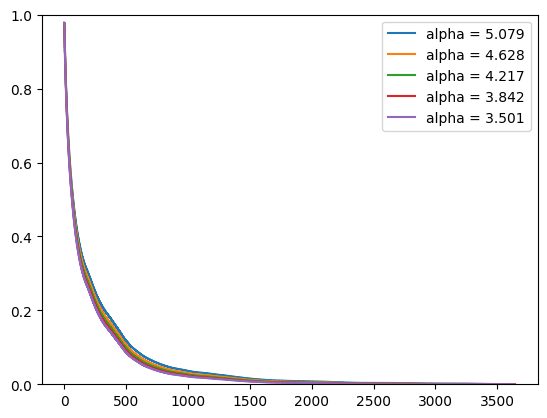

In [17]:
X = SimpleImputer(strategy="median").fit_transform(X)
estimator = CoxnetSurvivalAnalysis(l1_ratio=0.99, fit_baseline_model=True)
estimator.fit(X, y)

X_df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
surv_funcs = {}
for alpha in estimator.alphas_[:5]:
    print(f"Shape of X_df.iloc[:1]: {X_df.iloc[:1].shape}")
    surv_funcs[alpha] = estimator.predict_survival_function(
        X_df.iloc[:1], alpha=alpha)

for alpha, surv_alpha in surv_funcs.items():
     for fn in surv_alpha:
         plt.step(fn.x, fn(fn.x), where="post",
                  label=f"alpha = {alpha:.3f}")

plt.ylim(0, 1)
plt.legend()
plt.show()

In [18]:
# # Metric de concordance
# name_event = df_clean['Feu prévu'] 
# name_time = df_clean['décompte']
# # Fonction pour calculer le score de concordance
# def score(estimator, X, y):
#     """Returns the concordance index of the prediction."""
#     name_event, name_time = y.dtype.names
#     risk_score = estimator.predict(X)
#     if not getattr(estimator, "_predict_risk_score", True):
#         risk_score *= -1  # convert prediction on time scale to risk scale
#     result = concordance_index_censored(y[name_event], y[name_time], risk_score)
#     return result[0]

# # Calcul du score de concordance
# cindex = score(estimator, X, y)
# print(f"Concordance Index: {cindex}")

In [ ]:


# Étape 1 : prédire les fonctions de survie sur tout X
surv_funcs = estimator.predict_survival_function(X)

# Étape 2 : évaluer S(t) à t = 365 jours (exemple)
# t = 365  # Durée en jours pour l'évaluation
durees = [90, 180, 365]  # ou autre valeur de durée
df_plot = df_clean.copy()
# risques = [1 - fn(t) if t in fn.x else 1 - fn(fn.x[-1]) for fn in surv_funcs]
for t in durees:
    risques = []
    for fn in surv_funcs:
        # Si t dépasse la durée max connue de la fonction, on prend la dernière valeur
        if t in fn.x:
            risques.append(1 - fn(t))
        else:
            risques.append(1 - fn(fn.x[-1]))
    df_plot[f"risque_{t}j"] = risques
# Étape 3 : créer un DataFrame avec les positions
# df_plot = df_clean.copy()
# df_plot["risque_365j"] = risques

# Étape 4 : afficher avec plotly (attention aux noms de colonnes)
fig = px.scatter_map(
    df_plot,
    lat="latitude",
    lon="longitude",
    color="risque_90j",
    # color="risque_365j",
    color_continuous_scale="YlOrRd",
    hover_name="ville",
    hover_data={"risque_90j": True},
    # hover_data={"risque_365j": True},
    zoom=7,
    height=800
)

fig.update_layout(
    mapbox_style="open-street-map",
    title="Risque estimé selon la durée (jours)",
    margin={"r": 0, "t": 40, "l": 0, "b": 0},
    updatemenus=[
        dict(
            type="dropdown",
            direction="down",
            buttons=[
                dict(label="90 jours", method="restyle", args=[{"marker.color": [df_plot["risque_90j"]]}]),
                dict(label="180 jours", method="restyle", args=[{"marker.color": [df_plot["risque_180j"]]}]),
                dict(label="365 jours", method="restyle", args=[{"marker.color": [df_plot["risque_365j"]]}])
            ],
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.05,
            xanchor="left",
            y=1.1,
            yanchor="top"
        )
    ]
)

fig.show()

# fig.update_layout(
#     mapbox_style="open-street-map",
#     title="Risque estimé à 365 jours par commune",
#     margin={"r": 0, "t": 40, "l": 0, "b": 0}
# )

# fig.show()
